In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stat
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import pickle
from sklearn.metrics import *
import pandas as pd
import seaborn as sns
import statsmodels

In [2]:
from all_models import *

In [3]:
# read fit values
fits_single = pickle.load(open('fit_single_CV_704_auc.pickle', 'rb'))
fits_dual = pickle.load(open('fit_dual_CV_704_auc.pickle', 'rb'))
fits_hybrid = pickle.load(open('fit_hybrid_CV_704.pickle', 'rb'))
#fits_eight = pickle.load(open('fit_dual_eight_CV_704.pickle', 'rb'))
#fits_six = pickle.load(open('fit_six_CV_704.pickle', 'rb'))
#fits_mixed = pickle.load(open('fit_mixed_CV_704.pickle', 'rb'))
#fits_single_transfer = pickle.load(open('fit_single_CV_transfer.pickle', 'rb'))
#fits_dual_transfer = pickle.load(open('fit_dual_CV_transfer.pickle', 'rb'))
fits_alpha = pickle.load(open('fit_dual_2alpha_CV_704.pickle', 'rb'))

curvatures_smooth = pickle.load(open('curvatures_smooth.pickle', 'rb'))

curvatures_smooth = curvatures_smooth/90.0
curvatures = pickle.load(open('curvatures.pickle', 'rb'))

In [4]:
participant = 48
min(fits_single[0][participant][-3], fits_dual[0][participant][-3])

-591.6565176751773

In [5]:
num_itr = 1
all_A = np.zeros(60)
all_B = np.zeros(60*num_itr)
all_Af = np.zeros(60*num_itr)
all_Bf = np.zeros(60*num_itr)
all_As = np.zeros(60*num_itr)
all_Bs = np.zeros(60*num_itr)
all_alphas = np.zeros(60*num_itr)
for i in range(num_itr):
    all_A[i*60:(i+1)*60] = fits_single[i][:, 0]
    all_B[i*60:(i+1)*60] = fits_single[i][:, 1]
    all_Af[i*60:(i+1)*60] = fits_dual[i][:, 0]
    all_Bf[i*60:(i+1)*60] = fits_dual[i][:, 1]
    all_As[i*60:(i+1)*60] = fits_dual[i][:, 2]
    all_Bs[i*60:(i+1)*60] = fits_dual[i][:, 3]
    all_alphas[i*60:(i+1)*60] = 1- fits_hybrid[i][:, 0]

In [6]:
parameters_df = pd.DataFrame({'Participant_Id': np.tile(range(60), num_itr),
                         'Rotation': np.tile(['Sudden', 'Sudden', 'Gradual', 'Gradual'], 15*num_itr), 
                         'Emphasis': np.tile(['Speed', 'Accuracy'], 30*num_itr),
                         'A': all_A,
                         'B': all_B,
                         'Af': all_Af,
                         'Bf': all_Bf,
                         'As': all_As,
                         'Bs': all_Bs,
                         #'Alpha': all_alphas
                        })


In [7]:
parameter_means = parameters_df.groupby(['Participant_Id', 'Rotation', 'Emphasis']).mean().reset_index()
#parameter_means['ratio'] = (parameter_means['As'] )/(parameter_means['Af'] + parameter_means['As'])

In [8]:
parameter_means_melt = parameter_means.melt(id_vars=['Participant_Id', 'Rotation', 'Emphasis'], var_name='Parameters', value_name='Parameter_Values')

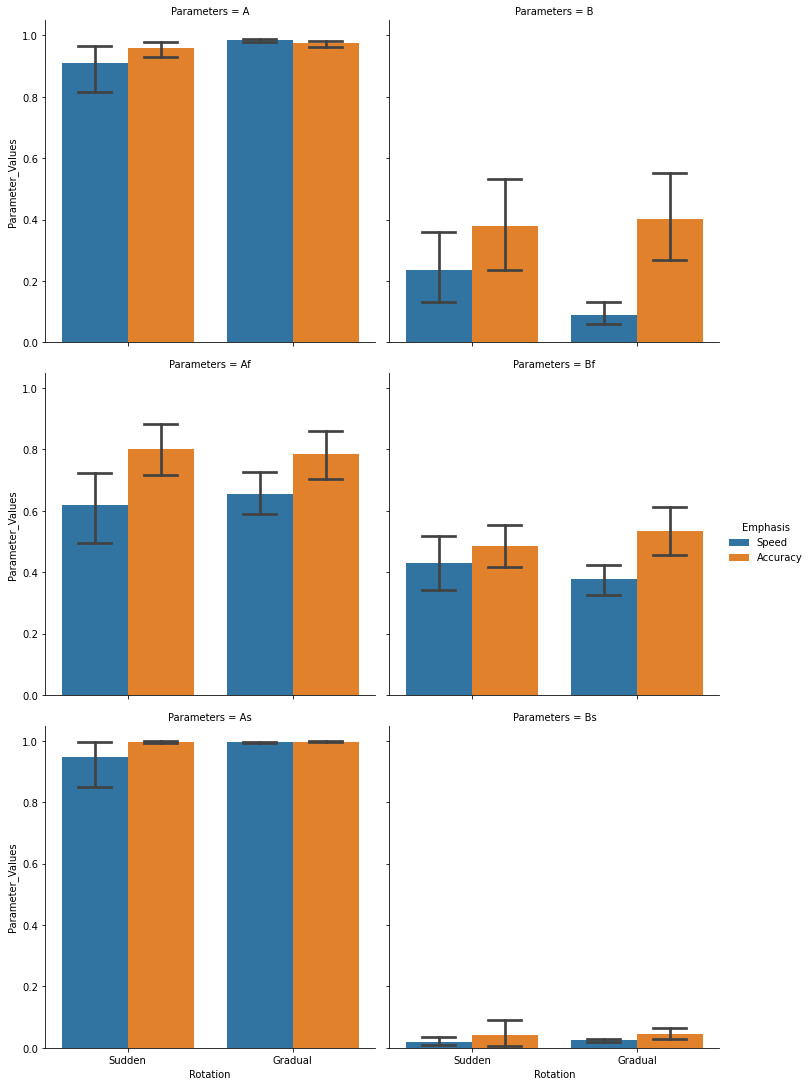

In [9]:
sns.catplot(x = 'Rotation', y = 'Parameter_Values', hue = 'Emphasis', col = 'Parameters', col_wrap = 2,
            data = parameter_means_melt, kind = 'bar', capsize = 0.2)


In [10]:
param = 'B'
stat.ttest_ind(parameter_means[param][parameter_means['Rotation'] == 'Gradual'], parameter_means[param][parameter_means['Rotation'] == 'Sudden'])

Ttest_indResult(statistic=-0.8777842574589279, pvalue=0.3836825248158997)

In [19]:
model = smf.ols('Bs~Rotation*Emphasis', data = parameter_means).fit()
aov = sm.stats.anova_lm(model)
aov

,df,sum_sq,mean_sq,F,PR(>F)
Rotation,1.0,0.000283,0.000283,0.107033,0.744767
Emphasis,1.0,0.006580,0.006580,2.487315,0.120400
Rotation:Emphasis,1.0,0.000005,0.000005,0.001757,0.966711
Residual,56.0,0.148147,0.002645,NaN,NaN


In [94]:
alpha_medians = alpha_df.groupby(['Participant_Id', 'Rotation', 'Emphasis']).median().reset_index()
alpha_means = alpha_df.groupby(['Participant_Id', 'Rotation', 'Emphasis']).mean().reset_index()


Text(0.5, 0.8793567452082017, '*')

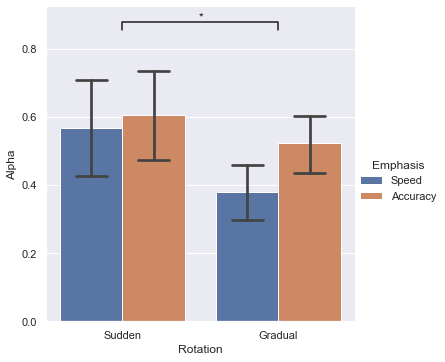

In [95]:
x1, x2 = 0, 1
y, h, col = alpha_means['Alpha'].max() - 0.2, 0.025, 'k'

sns.catplot(x = 'Rotation', y = 'Alpha', hue = 'Emphasis', data = alpha_means, kind = 'bar', capsize = 0.2)
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)


In [10]:
conc = pd.read_csv('conc.csv')

In [11]:
parameters_means['Model_Selected'] = 'Dual_Selected'

In [12]:
parameters_means['Model_Selected'][parameters_means['Participant_Id'].isin(np.unique(conc[conc['Dual_Selected'] < 50]['Participant_Id']))] = 'Single_Selected'

<ipython-input-12-d289fa70e1c0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters_means['Model_Selected'][parameters_means['Participant_Id'].isin(np.unique(conc[conc['Dual_Selected'] < 50]['Participant_Id']))] = 'Single_Selected'


In [13]:
parameters_means['Dual_Selected'] = 1
parameters_means['Dual_Selected'][parameters_means['Model_Selected'] == 'Single_Selected'] = 0

<ipython-input-13-0fc71f62f964>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parameters_means['Dual_Selected'][parameters_means['Model_Selected'] == 'Single_Selected'] = 0


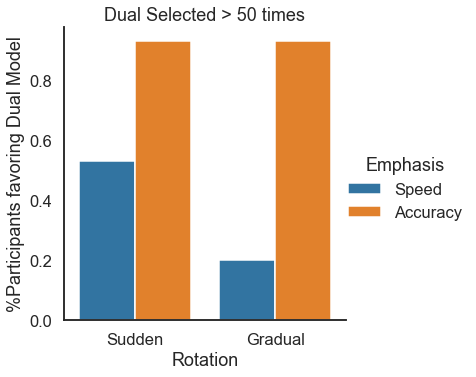

In [14]:
sns.set_context('talk')
sns.set_style('white')
cp = sns.catplot(data = parameters_means,
           x = 'Rotation', y = 'Dual_Selected', hue = 'Emphasis', kind = 'bar', ci = None)
plt.title('Dual Selected > 50 times')
cp.set_ylabels('%Participants favoring Dual Model')

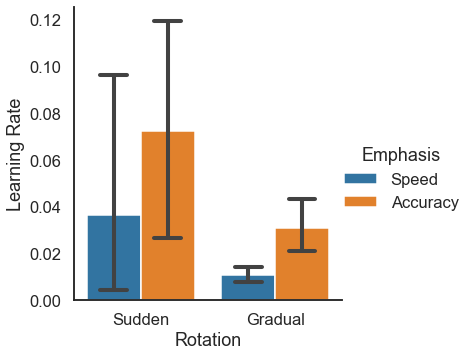

In [9]:
c = sns.catplot(data = parameters_means,
           x = 'Rotation', y = 'B', hue = 'Emphasis', kind = 'bar', capsize = 0.2)
c.set(ylabel = 'Learning Rate')
#plt.title('Best fit by Single state')
#sns.boxplot(data = parameters_means,
#           x = 'Model_Selected', y = 'B', 
#            hue = 'Emphasis')
#plt.ylim((-0.2, 0.5))

In [65]:
model = smf.ols('B~Rotation*Model_Selected', data = parameters_means).fit()
aov = sm.stats.anova_lm(model)
aov

,df,sum_sq,mean_sq,F,PR(>F)
Rotation,1.0,0.016925,0.016925,3.027798,0.087342
Model_Selected,1.0,0.023574,0.023574,4.217144,0.044698
Rotation:Model_Selected,1.0,0.007049,0.007049,1.260936,0.266265
Residual,56.0,0.313038,0.005590,NaN,NaN


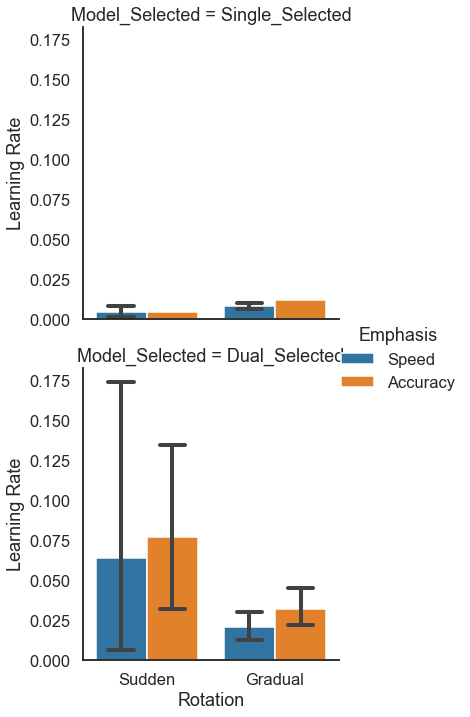

In [37]:
c = sns.catplot(data = parameters_means,
           x = 'Rotation', y = 'B', hue = 'Emphasis', kind = 'bar', capsize = 0.2, row = 'Model_Selected')
#plt.title('Best fit by Single state')
#plt.hlines(y = np.max(parameters_means['B'][parameters_means['Model_Selected'] == 'Single_Selected']), 
#           xmin = -0.5, xmax = 2, color = 'black', linestyles='--')
c.set(ylabel = 'Learning Rate')

Text(0.5, 1.0, 'Best fit by Single state')

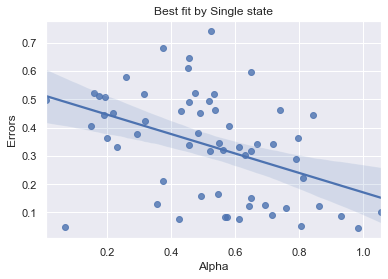

In [68]:
sns.regplot(data = parameters_means,
           x = 'Alpha', y = 'Errors')
plt.title('Best fit by Single state')


In [190]:
fits_dual = pickle.load(open('fit_dual_CV_704.pickle', 'rb'))

In [191]:
num_trials = 704
model_errors_fast = np.zeros((num_itr, 60, num_trials))
model_errors_slow = np.zeros((num_itr, 60, num_trials))
r_est = np.zeros((num_itr, 60, num_trials))
e_est = np.zeros((num_itr, 60, num_trials))
for i in range(num_itr):
    for participant in range(60):
        if participant%4 == 0 or participant%4 == 1:
            e_est[i][participant], r_est[i][participant], model_errors_fast[i][participant], model_errors_slow[i][participant]  = dual_model_sudden(704, fits_dual[i][participant][0], fits_dual[i][participant][1], fits_dual[i][participant][2], fits_dual[i][participant][3])
        else:
            e_est[i][participant], r_est[i][participant], model_errors_fast[i][participant], model_errors_slow[i][participant] = dual_model_gradual(num_trials, fits_dual[i][participant][0], fits_dual[i][participant][1], fits_dual[i][participant][2], fits_dual[i][participant][3])
        

In [192]:
estimates_df = pd.DataFrame({'Participant_Id': np.tile(np.repeat(np.arange(60), 704), num_itr), 
                             'Trial': np.tile(np.arange(704), 60*num_itr), 
                             'Block': np.tile(np.repeat(np.arange(1, 12), 64), 60*num_itr), 
                             'E_est': np.ravel(e_est),
                             'R_est': np.ravel(r_est),
                             'Fast_est': np.ravel(model_errors_fast),
                             'Slow_est': np.ravel(model_errors_slow),
                             'Rotation': np.tile(np.repeat(['Sudden', 'Sudden', 'Gradual', 'Gradual'], 704), 15*num_itr), 
                             'Emphasis': np.tile(np.repeat(['Speed', 'Accuracy'], 704), 30*num_itr), 
                             'slow_by_total': np.ravel(model_errors_slow)/(np.ravel(r_est) + 0.00001),
                             'fast_by_total': np.ravel(model_errors_fast)/(np.ravel(r_est) + 0.00001), 
                             'slow_by_fast': np.ravel(model_errors_slow)/(np.ravel(model_errors_fast) + 0.00001)

                            })
estimates_df['Slow-Fast'] = estimates_df['Slow_est'] - estimates_df['Fast_est']


In [193]:
estimate_means = estimates_df.groupby(['Participant_Id', 'Block', 'Rotation', 'Emphasis']).mean().reset_index()
estimate_means['Condition'] = estimate_means['Rotation'] + '_' + estimate_means['Emphasis']
estimate_means_melted = estimate_means.melt(['Participant_Id', 'Block', 'Rotation', 'Emphasis' ,'Trial',  'Condition'], var_name='Estimates')

In [194]:
estimate_sums = estimates_df.groupby(['Participant_Id', 'Block','Rotation', 'Emphasis']).sum().reset_index()
estimate_sums['Condition'] = estimate_sums['Rotation'] + '_' + estimate_sums['Emphasis']
estimate_sums_melted = estimate_sums.melt(['Participant_Id', 'Rotation', 'Emphasis' ,'Trial', 'Condition'], var_name='Estimates')

,df,sum_sq,mean_sq,F,PR(>F)
Rotation,1.0,0.121640,0.121640,1.816415,0.178310
Emphasis,1.0,0.280300,0.280300,4.185646,0.041255
Rotation:Emphasis,1.0,1.400396,1.400396,20.911708,0.000006
Residual,536.0,35.894345,0.066967,NaN,NaN


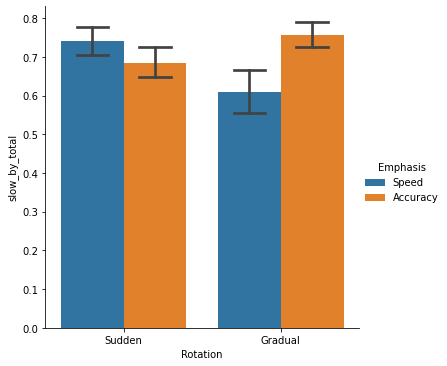

In [195]:
sns.catplot(x = 'Rotation', y = 'slow_by_total', hue = 'Emphasis',
            data = estimate_means[estimate_means['Block'] < 10], kind = 'bar', capsize = 0.2)
model = smf.ols('slow_by_total~Rotation*Emphasis', data = estimate_means[estimate_means['Block'] < 10]).fit()
aov = sm.stats.anova_lm(model)
aov

(0.0, 1.0)

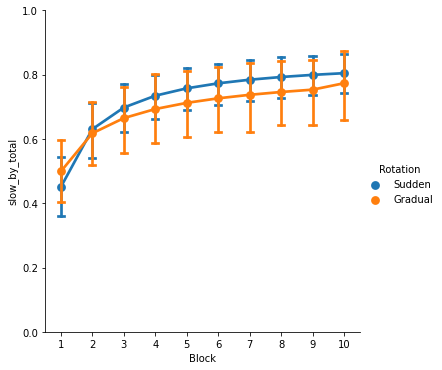

In [183]:
sns.catplot(x = 'Block', y = 'slow_by_total', hue = 'Rotation', 
            data = estimate_means[estimate_means['Block'] < 11], kind = 'point', capsize = 0.2)
plt.ylim((0, 1))

(0.0, 1.0)

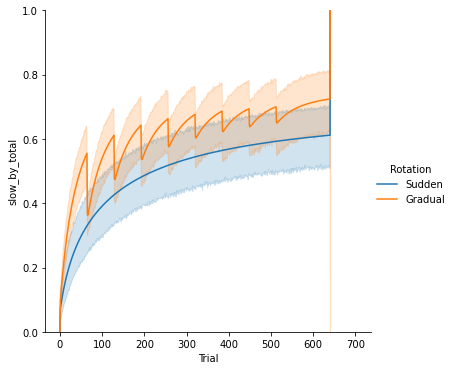

In [101]:
sns.relplot(x = 'Trial', y = 'slow_by_total', hue = 'Rotation', 
            data = estimates_df, kind = 'line')
plt.ylim((0, 1))

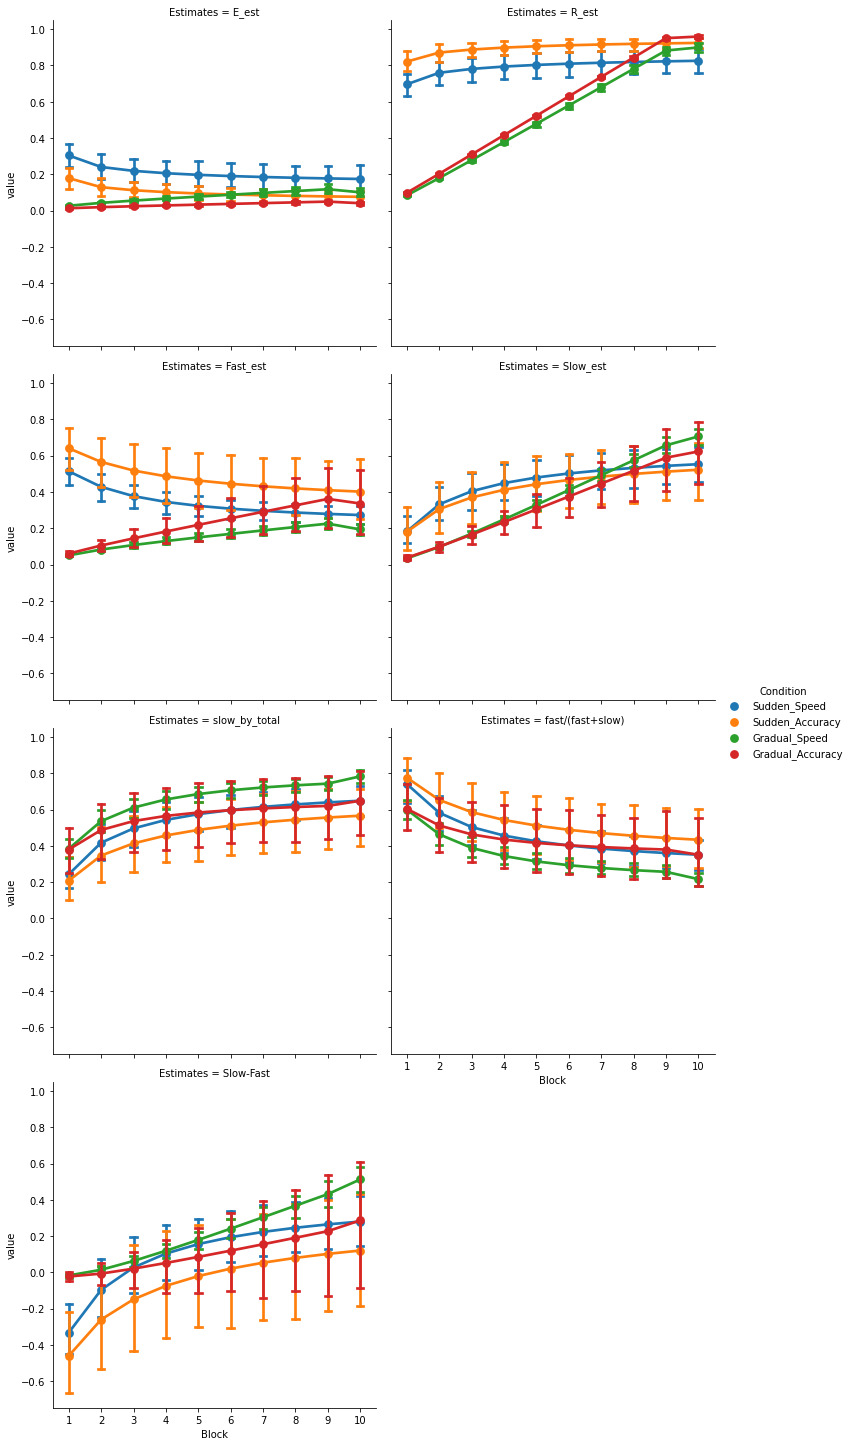

In [103]:
sns.catplot(x = 'Block', y = 'value', hue = 'Condition', col = 'Estimates', col_wrap=2, 
            data = estimate_means_melted[estimate_means_melted['Block'] < 11], kind = 'point', capsize = 0.2)

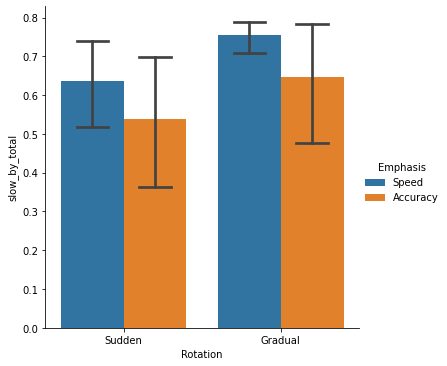

In [74]:
sns.catplot(data = estimate_means[estimate_means['Block'] == 9],
           x = 'Rotation', y = 'slow_by_total', hue = 'Emphasis', 
                kind = 'bar', capsize = 0.2)


PatsyError: Error evaluating factor: NameError: name 'fast_by_total' is not defined
    fast_by_total~Rotation*Emphasis
    ^^^^^^^^^^^^^